## Regular Least Squares with Temporal Matrix

In [34]:
import numpy as np
import nengo
import matplotlib.pyplot as plt

In [35]:
def calculate_loss_function(real_data, predicted_data):
    return np.mean((real_data - predicted_data)**2)

# Create Nengo network

In [36]:
# --- Parameters ---
T = 10.0          # Simulation duration (s)
dt = 0.001        # Time step (s)
n_neurons = 100   # Number of neurons
tau_syn = 0.1    # Synaptic time constant (s)

In [37]:
with nengo.Network(seed=10) as model:
    noise_process = nengo.processes.WhiteSignal(period=T, high=10.0, rms=0.25, seed=11)
    input_node = nengo.Node(noise_process, size_out=1)

    ens = nengo.Ensemble(n_neurons=n_neurons,
                        dimensions=1,
                        neuron_type=nengo.LIF(),
                        max_rates=nengo.dists.Uniform(30, 60),
                        intercepts=nengo.dists.Uniform(-0.7, 0.7)
                        )

    nengo.Connection(input_node, ens, synapse=None, seed=1)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_activity = nengo.Probe(ens.neurons, synapse=0.2, sample_every=dt)
    p_decoded = nengo.Probe(ens, synapse=tau_syn, sample_every=dt)

In [38]:
# Simulate the model
sim = nengo.Simulator(model, dt=dt)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

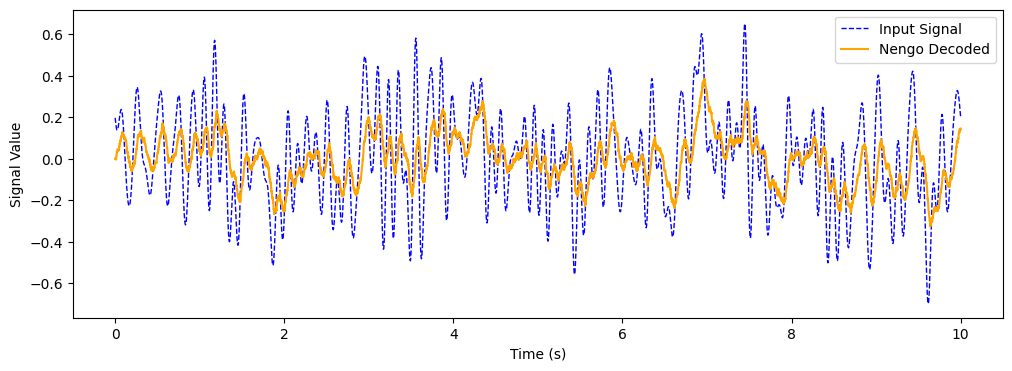

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(sim.trange(), sim.data[p_input], label='Input Signal', color='blue', linewidth=1, linestyle='--');
plt.plot(sim.trange(), sim.data[p_decoded], label='Nengo Decoded', color='orange');
plt.xlabel('Time (s)'); plt.ylabel('Signal Value'); plt.legend();

# FIR Decoding

In [40]:
coeffs, _, _, _ = np.linalg.lstsq(sim.data[p_activity], sim.data[p_input], rcond=None)

# Test on an unseen signal

In [41]:
with nengo.Network(seed=10) as model:
    noise_process = nengo.processes.WhiteSignal(period=T, high=10.0, rms=0.25, seed=121)
    input_node = nengo.Node(noise_process, size_out=1)

    ens = nengo.Ensemble(n_neurons=n_neurons,
                        dimensions=1,
                        neuron_type=nengo.LIF(),
                        max_rates=nengo.dists.Uniform(30, 60),
                        intercepts=nengo.dists.Uniform(-0.7, 0.7)
                        )

    nengo.Connection(input_node, ens, synapse=None, seed=1)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_activity = nengo.Probe(ens.neurons, synapse=0.2, sample_every=dt)
    p_decoded = nengo.Probe(ens, synapse=tau_syn, sample_every=dt)

In [42]:
sim = nengo.Simulator(model, dt=dt)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [43]:
alif_decoded = sim.data[p_activity] @ coeffs

Instantaneous Decoding Loss:  0.06891790555798846
Nengo Decoding Loss:  0.044737636699953884


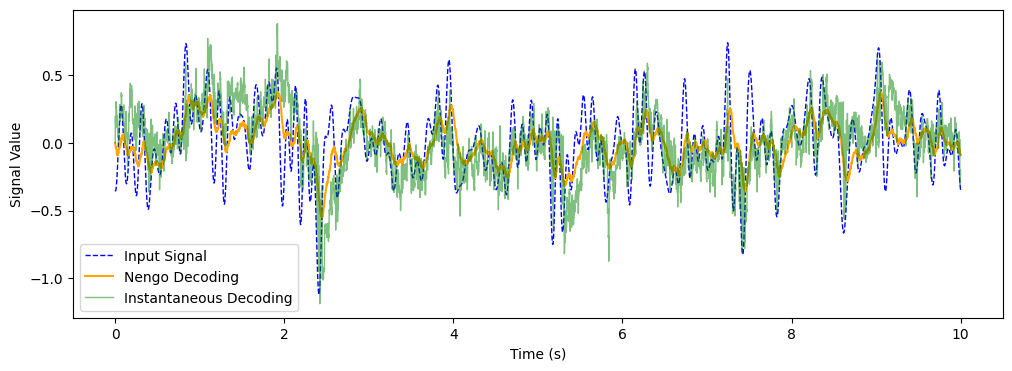

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(sim.trange(), sim.data[p_input], label='Input Signal', color='blue', linewidth=1, linestyle='--');
plt.plot(sim.trange(), sim.data[p_decoded], label='Nengo Decoding', color='orange');
plt.plot(sim.trange(), alif_decoded, label='Instantaneous Decoding', color='green', linewidth=1, alpha=0.5);
plt.xlabel('Time (s)'); plt.ylabel('Signal Value'); plt.legend();
print('Instantaneous Decoding Loss: ', calculate_loss_function(sim.data[p_input], alif_decoded))
print('Nengo Decoding Loss: ', calculate_loss_function(sim.data[p_input], sim.data[p_decoded]))